# Parkinsons Disease Detection with FBANKs and linear model

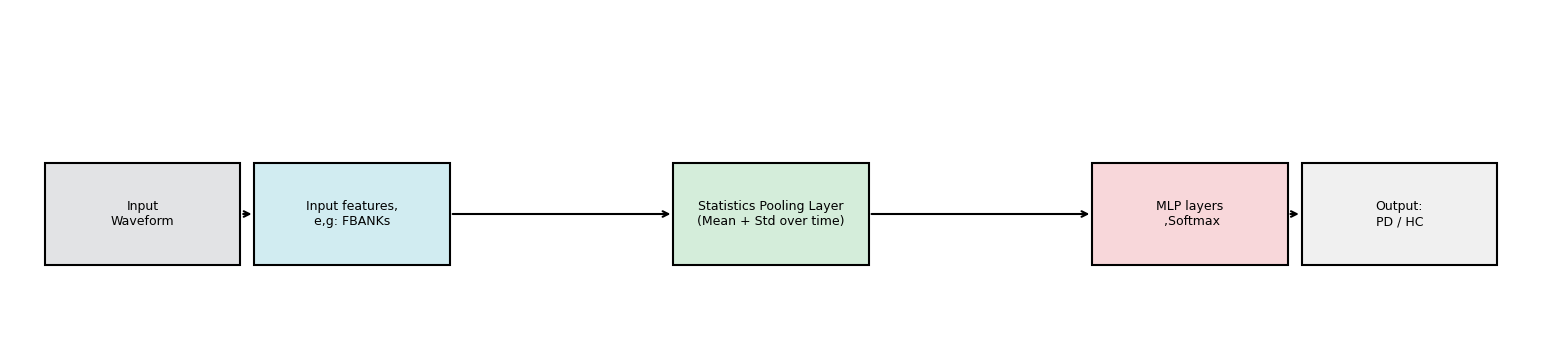

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_block(ax, text, xy, width=2.8, height=1.2, color="#cce5ff"):
    x, y = xy
    box = Rectangle((x, y), width, height, edgecolor='black', facecolor=color, lw=1.5)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text, ha='center', va='center', fontsize=9, wrap=True)

def draw_arrow(ax, start, end):
    ax.annotate('', xy=end, xytext=start,
                arrowprops=dict(arrowstyle='->', lw=1.5))

fig, ax = plt.subplots(figsize=(16, 4))
ax.set_xlim(0, 22)
ax.set_ylim(0, 4)
ax.axis('off')

# Coordinates for blocks (left to right)
blocks = [
    ("Input\nWaveform", (0.5, 1), "#e2e3e5"),
    ("Input features,\ne,g: FBANKs", (3.5, 1), "#d1ecf1"),
    ("Statistics Pooling Layer\n(Mean + Std over time)", (9.5, 1), "#d4edda"),
    ("MLP layers\n ,Softmax", (15.5, 1), "#f8d7da"),
    ("Output:\nPD / HC", (18.5, 1), "#f0f0f0"),
]

# Draw blocks
for text, pos, color in blocks:
    draw_block(ax, text, pos, color=color)

# Draw arrows between blocks
for i in range(len(blocks) - 1):
    x_start = blocks[i][1][0] + 2.8
    x_end = blocks[i+1][1][0]
    draw_arrow(ax, (x_start, 1.6), (x_end, 1.6))

plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.1)

# plt.savefig("ecapa_tdnn_diagram.png", dpi=300, bbox_inches='tight')
plt.show()


## imports

In [4]:
from plot_tensorboard import plot_training
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys


2025-04-25 20:00:50.965800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 20:00:51.322394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 20:00:51.460219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 20:00:52.245512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 20:01:00.592856: W tensorflow/comp

### hparams file

In [18]:
%%file hparams_linearmodel_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/linearmodel/fulldataset/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 16
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
train_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    drop_last: True
eval_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: False
    drop_last: False

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# # Embedding model: from variable size recordings gets a fixed size embedding vector
# embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
#     in_channels: !ref <n_mels>
#     activation: !name:torch.nn.LeakyReLU
#     tdnn_blocks: 5
#     tdnn_channels: [64, 64, 64, 64, 128]
#     tdnn_kernel_sizes: [5, 3, 3, 1, 1]
#     tdnn_dilations: [1, 2, 3, 1, 1]
#     lin_neurons: !ref <emb_dim>

# # Clasifier applied on top of the embeddings
# classifier: !new:speechbrain.lobes.models.Xvector.Classifier
#     input_shape: [null, null, !ref <emb_dim>]
#     activation: !name:torch.nn.LeakyReLU
#     lin_blocks: 1
#     lin_neurons: !ref <emb_dim>
#     out_neurons: !ref <n_classes>

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp1: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <n_mels>
    n_neurons: !ref <emb_dim>
    bias: False
output_mlp2: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <emb_dim>
    n_neurons: !ref <n_classes>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    # embedding_model: !ref <embedding_model>
    # classifier: !ref <classifier>
    avg_pool: !ref <avg_pool>
    output_mlp1: !ref <output_mlp1>
    output_mlp2: !ref <output_mlp2>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        # embedding_model: !ref <embedding_model>
        # classifier: !ref <classifier>
        output_mlp1: !ref <output_mlp1>
        output_mlp2: !ref <output_mlp2>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_linearmodel_fbanks.yaml


### train python file

In [14]:
%%file train_linearmodel_fbanks.py
# Your code here

#!/usr/bin/env python3
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np


# Brain class for speech enhancement training
class DetectorBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines
        batch = batch.to(self.device)

        # Feature extraction and normalization
        wavs, lens = batch.sig
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        stats_out = self.hparams.avg_pool(feats, lens)
        embeddings = self.modules.output_mlp1(stats_out)
        predictions = self.modules.output_mlp2(embeddings)
        predictions = self.hparams.log_softmax(predictions)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Your code here. Aim for 7-8 lines
        _, lens = batch.sig
        detection_id, _ = batch.detection_id_encoded
        # print('prediction', predictions.shape)
        # print('detection_id', detection_id.shape)

        # Compute the cost function
        loss = sb.nnet.losses.nll_loss(predictions, detection_id, lens)

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, detection_id, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, detection_id, lens)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = detection_id.cpu().detach().numpy().squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1).squeeze(-1)
        if stage == sb.Stage.TEST:
            # print('test y_true= ', y_true)
            # print('test y_pred= ', y_pred)
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        self.acc_metric.append(
            batch.id, predict=predictions, target=detection_id, lengths=lens
        )

        return loss


    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            # print("Predictions shape:", predict.shape)
            # print("Detection ID shape:", target.shape)
            # print("Lengths shape:", lengths.shape)
            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.n_classes, self.hparams.n_classes),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=valid_stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # self.hparams.train_logger.log_stats(
            #     {"Epoch loaded": self.hparams.epoch_counter.current},
            #     test_stats=stats,
            # )
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)

        # Resampling
        # print('input signal(s) shape: ', sig.squeeze().shape)
        sig = torchaudio.functional.resample(sig.squeeze(0), fs, hparams["sample_rate"])
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        """Defines the pipeline to process the detection labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    # hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Create dataset objects "train", "valid", and "test".
    datasets, label_encoder = dataio_prep(hparams)
    
    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_options"],
        valid_loader_kwargs=hparams["eval_dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["eval_dataloader_options"],
    )



Overwriting train_linearmodel_fbanks.py


In [15]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/linearmodel/fulldataset/FBANKs/1986

# Run Training
!{sys.executable} train_linearmodel_fbanks.py hparams_linearmodel_fbanks.yaml --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/linearmodel/fulldataset/FBANKs/1986
2025-04-23 01:35:03.747261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 01:35:03.770570: E external/local_xla/xla/stream_executor/cuda/cu

### training log output:
```
Epoch: 1, lr: 1.00e-03 - train loss: 5.63e-01, train acc: 7.42e-01 - valid loss: 5.23e-01, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 2, lr: 9.36e-04 - train loss: 4.71e-01, train acc: 8.16e-01 - valid loss: 5.20e-01, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 3, lr: 8.71e-04 - train loss: 4.25e-01, train acc: 8.33e-01 - valid loss: 4.97e-01, valid acc: 6.77e-01, valid error: 3.23e-01
Epoch: 4, lr: 8.07e-04 - train loss: 3.96e-01, train acc: 8.37e-01 - valid loss: 5.03e-01, valid acc: 6.98e-01, valid error: 3.02e-01
Epoch: 5, lr: 7.43e-04 - train loss: 3.79e-01, train acc: 8.45e-01 - valid loss: 5.27e-01, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 6, lr: 6.79e-04 - train loss: 3.77e-01, train acc: 8.44e-01 - valid loss: 5.20e-01, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 7, lr: 6.14e-04 - train loss: 3.65e-01, train acc: 8.47e-01 - valid loss: 4.97e-01, valid acc: 7.50e-01, valid error: 2.50e-01
Epoch: 8, lr: 5.50e-04 - train loss: 3.63e-01, train acc: 8.41e-01 - valid loss: 4.56e-01, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 9, lr: 4.86e-04 - train loss: 3.56e-01, train acc: 8.52e-01 - valid loss: 4.79e-01, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 10, lr: 4.21e-04 - train loss: 3.56e-01, train acc: 8.41e-01 - valid loss: 4.71e-01, valid acc: 7.29e-01, valid error: 2.71e-01
Epoch: 11, lr: 3.57e-04 - train loss: 3.45e-01, train acc: 8.47e-01 - valid loss: 4.72e-01, valid acc: 7.29e-01, valid error: 2.71e-01
Epoch: 12, lr: 2.93e-04 - train loss: 3.42e-01, train acc: 8.50e-01 - valid loss: 4.74e-01, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 13, lr: 2.29e-04 - train loss: 3.39e-01, train acc: 8.48e-01 - valid loss: 4.78e-01, valid acc: 7.40e-01, valid error: 2.60e-01
Epoch: 14, lr: 1.64e-04 - train loss: 3.38e-01, train acc: 8.52e-01 - valid loss: 4.62e-01, valid acc: 7.29e-01, valid error: 2.71e-01
Epoch: 15, lr: 1.00e-04 - train loss: 3.36e-01, train acc: 8.55e-01 - valid loss: 4.55e-01, valid acc: 7.29e-01, valid error: 2.71e-01
Epoch loaded: 8, 
 Per Class Accuracy: 
0: 0.896
1: 0.500, 
 Confusion Matrix: 
[[43  5]
 [19 19]]
 - test loss: 5.44e-01, test acc: 7.33e-01, test error: 2.79e-01
```
'PD' => 0

'HC' => 1


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


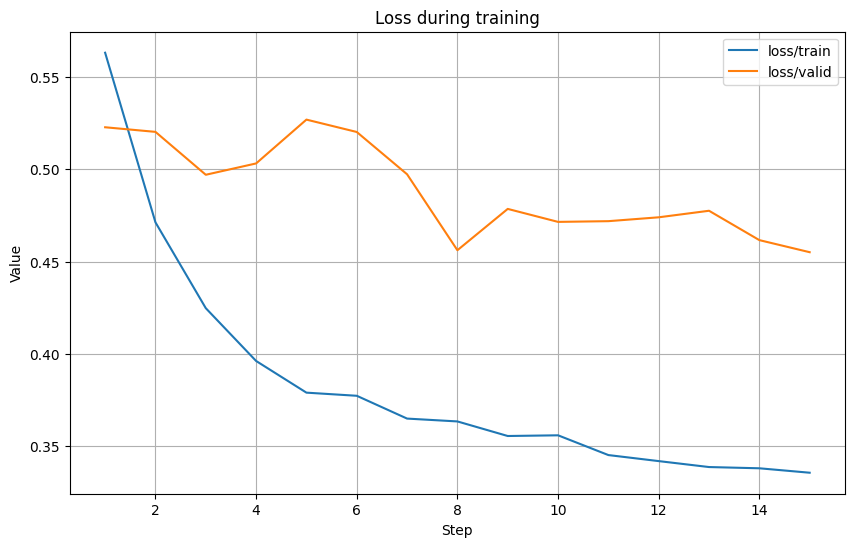

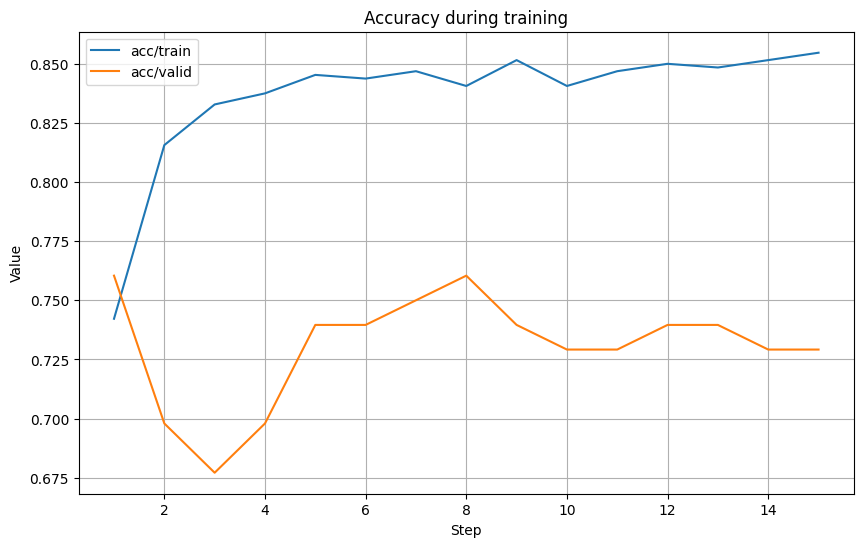

In [16]:

event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/linearmodel/fulldataset/FBANKs/1986/tb_logs/events.out.tfevents.1745386513.ul-val-pr-gpu05.l.ul.ca.1944397.0"
plot_training(event_file)



## use deeper MLP

### haprams file

In [6]:
%%file hparams_deeperlinear_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlineartest/fulldataset/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 16
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 512 # dimensionality of the embeddings
train_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    drop_last: True
eval_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: False
    drop_last: False

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp1: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <n_mels>
    n_neurons: !ref <emb_dim>
    bias: False
output_mlp2: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <emb_dim>
    n_neurons: !ref <emb_dim>
    bias: False
output_mlp3: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <emb_dim>
    n_neurons: !ref <n_classes>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    avg_pool: !ref <avg_pool>
    output_mlp1: !ref <output_mlp1>
    output_mlp2: !ref <output_mlp2>
    output_mlp3: !ref <output_mlp3>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        # embedding_model: !ref <embedding_model>
        # classifier: !ref <classifier>
        output_mlp1: !ref <output_mlp1>
        output_mlp2: !ref <output_mlp2>
        output_mlp3: !ref <output_mlp3>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_deeperlinear_fbanks.yaml


### train file

In [7]:
%%file train_deeperlinear_fbanks.py
# Your code here

#!/usr/bin/env python3
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np


# Brain class for speech enhancement training
class DetectorBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines
        batch = batch.to(self.device)

        # Feature extraction and normalization
        wavs, lens = batch.sig
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        stats_out = self.hparams.avg_pool(feats, lens)
        embeddings = self.modules.output_mlp1(stats_out)
        embeddings = self.modules.output_mlp2(embeddings)
        predictions = self.modules.output_mlp3(embeddings)
        predictions = self.hparams.log_softmax(predictions)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Your code here. Aim for 7-8 lines
        _, lens = batch.sig
        detection_id, _ = batch.detection_id_encoded
        print('prediction', predictions.shape)
        # print('detection_id', detection_id.shape)

        # Compute the cost function
        loss = sb.nnet.losses.nll_loss(predictions, detection_id, lens)

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, detection_id, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, detection_id, lens)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = detection_id.cpu().detach().numpy().squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1).squeeze(-1)
        if stage == sb.Stage.TEST:
            # print('test y_true= ', y_true)
            # print('test y_pred= ', y_pred)
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        self.acc_metric.append(
            batch.id, predict=predictions, target=detection_id, lengths=lens
        )

        return loss


    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            # print("Predictions shape:", predict.shape)
            # print("Detection ID shape:", target.shape)
            # print("Lengths shape:", lengths.shape)
            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.n_classes, self.hparams.n_classes),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=valid_stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # self.hparams.train_logger.log_stats(
            #     {"Epoch loaded": self.hparams.epoch_counter.current},
            #     test_stats=stats,
            # )
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)

        # Resampling
        # print('input signal(s) shape: ', sig.squeeze().shape)
        sig = torchaudio.functional.resample(sig.squeeze(0), fs, hparams["sample_rate"])
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        """Defines the pipeline to process the detection labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    # hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Create dataset objects "train", "valid", and "test".
    datasets, label_encoder = dataio_prep(hparams)
    
    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_options"],
        valid_loader_kwargs=hparams["eval_dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["eval_dataloader_options"],
    )



Overwriting train_deeperlinear_fbanks.py


In [8]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlineartest/fulldataset/FBANKs/1986
import sys
# Run Training
!{sys.executable} train_deeperlinear_fbanks.py hparams_deeperlinear_fbanks.yaml --device='cuda:0' --number_of_epochs=1 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlineartest/fulldataset/FBANKs/1986
2025-04-24 00:36:23.420392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-24 00:36:23.442622: E external/local_xla/xla/stream_executor/cu

In [7]:
import speechbrain
import torch
import numpy
import torchvision

In [8]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlinear/fulldataset/FBANKs/1986

# Run Training
!{sys.executable} train_deeperlinear_fbanks.py hparams_deeperlinear_fbanks.yaml --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlineartest/fulldataset/FBANKs/1986
2025-04-25 20:33:05.347756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 20:33:05.370115: E external/local_xla/xla/stream_executor/cu

### Training log output
```
Epoch: 1, lr: 1.00e-03 - train loss: 5.54e-01, train acc: 7.66e-01 - valid loss: 5.15e-01, valid acc: 6.56e-01, valid error: 3.44e-01
Epoch: 2, lr: 9.36e-04 - train loss: 4.02e-01, train acc: 8.12e-01 - valid loss: 4.69e-01, valid acc: 6.67e-01, valid error: 3.33e-01
Epoch: 3, lr: 8.71e-04 - train loss: 3.84e-01, train acc: 8.42e-01 - valid loss: 4.21e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 4, lr: 8.07e-04 - train loss: 3.70e-01, train acc: 8.27e-01 - valid loss: 4.38e-01, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 5, lr: 7.43e-04 - train loss: 3.47e-01, train acc: 8.52e-01 - valid loss: 4.18e-01, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 6, lr: 6.79e-04 - train loss: 3.40e-01, train acc: 8.55e-01 - valid loss: 4.78e-01, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 7, lr: 6.14e-04 - train loss: 3.48e-01, train acc: 8.53e-01 - valid loss: 5.29e-01, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 8, lr: 5.50e-04 - train loss: 3.48e-01, train acc: 8.42e-01 - valid loss: 3.84e-01, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 9, lr: 4.86e-04 - train loss: 3.31e-01, train acc: 8.63e-01 - valid loss: 4.08e-01, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 10, lr: 4.21e-04 - train loss: 3.23e-01, train acc: 8.61e-01 - valid loss: 3.63e-01, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 11, lr: 3.57e-04 - train loss: 3.30e-01, train acc: 8.53e-01 - valid loss: 3.57e-01, valid acc: 7.92e-01, valid error: 2.08e-01
Epoch: 12, lr: 2.93e-04 - train loss: 3.13e-01, train acc: 8.52e-01 - valid loss: 3.69e-01, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 13, lr: 2.29e-04 - train loss: 3.08e-01, train acc: 8.56e-01 - valid loss: 3.81e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 14, lr: 1.64e-04 - train loss: 3.06e-01, train acc: 8.63e-01 - valid loss: 4.03e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 15, lr: 1.00e-04 - train loss: 2.99e-01, train acc: 8.67e-01 - valid loss: 3.57e-01, valid acc: 7.92e-01, valid error: 2.08e-01
Epoch loaded: 14, 
 Per Class Accuracy: 
0: 0.896
1: 0.816, 
 Confusion Matrix: 
[[43  5]
 [ 7 31]]
 - test loss: 4.01e-01, test acc: 8.75e-01, test error: 1.40e-01
```

'PD' => 0

'HC' => 1


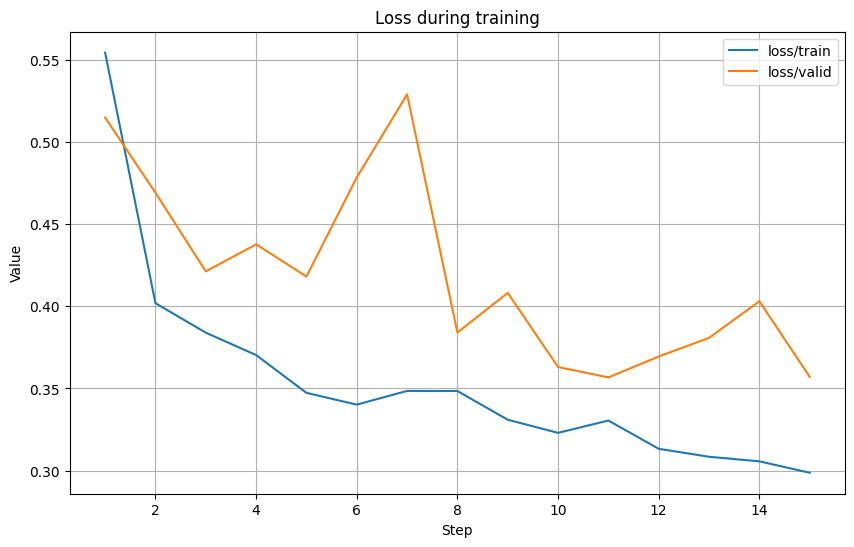

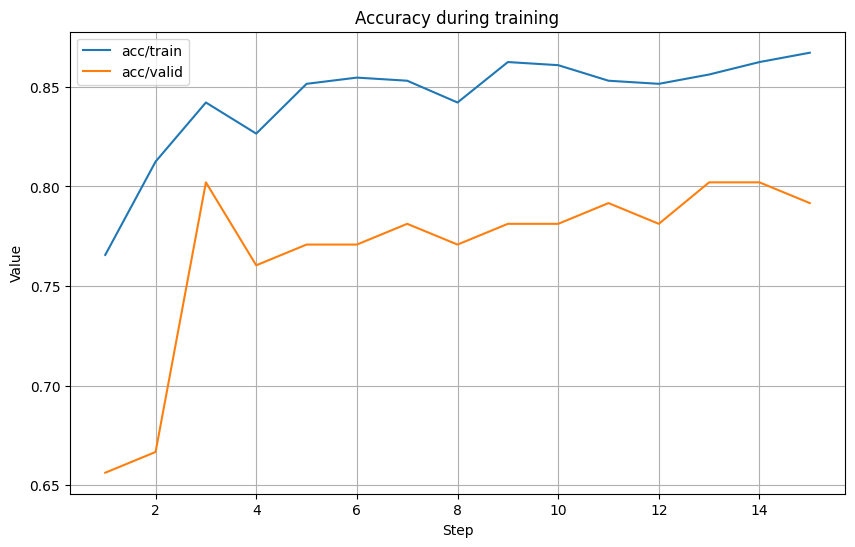

In [26]:

event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlinear/fulldataset/FBANKs/1986/tb_logs/events.out.tfevents.1745388541.ul-val-pr-gpu05.l.ul.ca.1949759.0"
plot_training(event_file)



## 1024 emb

### haprams file

In [1]:
%%file hparams_deeperlinear_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlineartest1024/fulldataset/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 16
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 1024 # dimensionality of the embeddings
train_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    drop_last: True
eval_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: False
    drop_last: False

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

avg_pool: !new:speechbrain.nnet.pooling.StatisticsPooling
    return_std: False

output_mlp1: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <n_mels>
    n_neurons: !ref <emb_dim>
    bias: False
output_mlp2: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <emb_dim>
    n_neurons: !ref <emb_dim>
    bias: False
output_mlp3: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <emb_dim>
    n_neurons: !ref <n_classes>
    bias: False

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    avg_pool: !ref <avg_pool>
    output_mlp1: !ref <output_mlp1>
    output_mlp2: !ref <output_mlp2>
    output_mlp3: !ref <output_mlp3>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        # embedding_model: !ref <embedding_model>
        # classifier: !ref <classifier>
        output_mlp1: !ref <output_mlp1>
        output_mlp2: !ref <output_mlp2>
        output_mlp3: !ref <output_mlp3>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_deeperlinear_fbanks.yaml


In [5]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlinear1024/fulldataset/FBANKs/1986
import sys
# Run Training
!{sys.executable} train_deeperlinear_fbanks.py hparams_deeperlinear_fbanks.yaml --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/deeperlineartest1024/fulldataset/FBANKs/1986
2025-04-25 20:03:11.212791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 20:03:11.234915: E external/local_xla/xla/stream_executo

### output log:
```
Epoch: 1, lr: 1.00e-03 - train loss: 6.86e-01, train acc: 7.41e-01 - valid loss: 5.89e-01, valid acc: 7.29e-01, valid error: 2.71e-01
Epoch: 2, lr: 9.36e-04 - train loss: 4.09e-01, train acc: 8.16e-01 - valid loss: 4.45e-01, valid acc: 7.29e-01, valid error: 2.71e-01
Epoch: 3, lr: 8.71e-04 - train loss: 3.89e-01, train acc: 8.48e-01 - valid loss: 4.20e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 4, lr: 8.07e-04 - train loss: 3.61e-01, train acc: 8.31e-01 - valid loss: 4.11e-01, valid acc: 7.92e-01, valid error: 2.08e-01
Epoch: 5, lr: 7.43e-04 - train loss: 3.45e-01, train acc: 8.52e-01 - valid loss: 4.08e-01, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 6, lr: 6.79e-04 - train loss: 3.46e-01, train acc: 8.52e-01 - valid loss: 4.69e-01, valid acc: 7.71e-01, valid error: 2.29e-01
Epoch: 7, lr: 6.14e-04 - train loss: 3.50e-01, train acc: 8.53e-01 - valid loss: 5.21e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 8, lr: 5.50e-04 - train loss: 3.52e-01, train acc: 8.41e-01 - valid loss: 3.80e-01, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 9, lr: 4.86e-04 - train loss: 3.29e-01, train acc: 8.55e-01 - valid loss: 4.26e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 10, lr: 4.21e-04 - train loss: 3.23e-01, train acc: 8.63e-01 - valid loss: 3.64e-01, valid acc: 7.81e-01, valid error: 2.19e-01
Epoch: 11, lr: 3.57e-04 - train loss: 3.30e-01, train acc: 8.56e-01 - valid loss: 3.53e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 12, lr: 2.93e-04 - train loss: 3.09e-01, train acc: 8.58e-01 - valid loss: 3.84e-01, valid acc: 7.60e-01, valid error: 2.40e-01
Epoch: 13, lr: 2.29e-04 - train loss: 3.09e-01, train acc: 8.58e-01 - valid loss: 3.79e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch: 14, lr: 1.64e-04 - train loss: 3.04e-01, train acc: 8.61e-01 - valid loss: 3.97e-01, valid acc: 8.12e-01, valid error: 1.88e-01
Epoch: 15, lr: 1.00e-04 - train loss: 2.94e-01, train acc: 8.64e-01 - valid loss: 3.55e-01, valid acc: 8.02e-01, valid error: 1.98e-01
Epoch loaded: 14, 
 Per Class Accuracy: 
0: 0.833
1: 0.816, 
 Confusion Matrix: 
[[40  8]
 [ 7 31]]
 - test loss: 4.02e-01, test acc: 8.26e-01, test error: 1.74e-01
```

'PD' => 0

'HC' => 1

